# Medical Cost with Random Forest Regression

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
sns.set(style="darkgrid")

## Prepare Dataset

### Read data

In [26]:
# Read dataset
file_path = '../work1/data/insurance.csv'
insurance_data = pd.read_csv(file_path)

In [27]:
# Show sample data
insurance_data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [28]:
# Check shape, it has 1338 rows and 7 cols
insurance_data.shape

(1338, 7)

In [29]:
# Check info. then sex, smoker and region are object type need to convert before use
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [30]:
# Check basic stat
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [31]:
# Check missing values
insurance_data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Check outliers

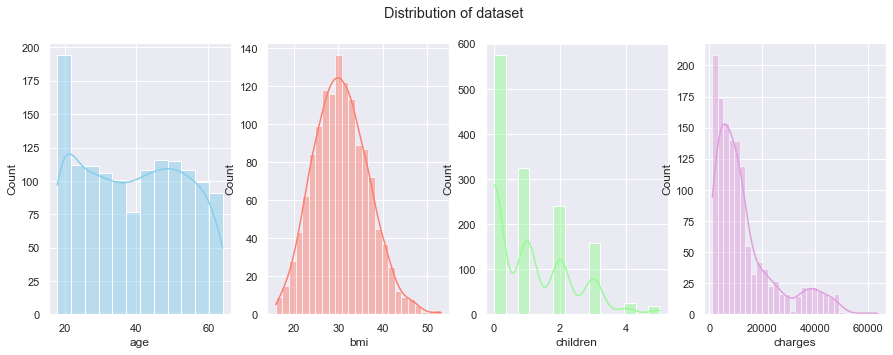

In [32]:
# Plot distribution of dataset
fig1, ax1 = plt.subplots(1, 4, figsize=(15, 5))
sns.histplot(data=insurance_data['age'], color='skyblue', kde=True, ax=ax1[0])
sns.histplot(data=insurance_data['bmi'], color='salmon', kde=True, ax=ax1[1])
sns.histplot(data=insurance_data['children'], color='palegreen', kde=True, ax=ax1[2])
sns.histplot(data=insurance_data['charges'], color='plum', kde=True)

fig1.suptitle('Distribution of dataset')
plt.show()

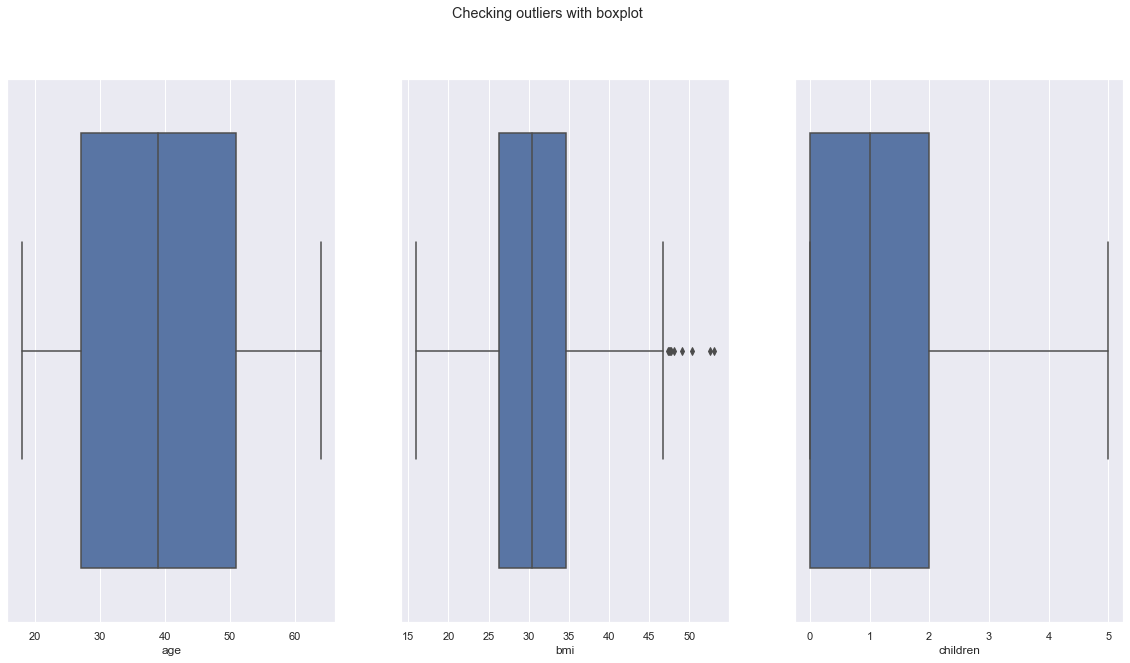

In [33]:
# Check outliers with boxplot
fig2, ax2 = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(data=insurance_data, x='age', ax=ax2[0])
sns.boxplot(data=insurance_data, x='bmi', ax=ax2[1])
sns.boxplot(data=insurance_data, x='children', ax=ax2[2])

fig2.suptitle('Checking outliers with boxplot')
plt.show()

In [34]:
cleaned_data = insurance_data.copy()

# Get IQR
q1 = insurance_data[['age', 'bmi', 'children']].quantile(0.25)
q3 = insurance_data[['age', 'bmi', 'children']].quantile(0.75)
iqr = q3-q1
print(iqr)

age         24.0000
bmi          8.3975
children     2.0000
dtype: float64


In [35]:
# Get upper and lower
upper = np.where(insurance_data[['age', 'bmi', 'children']] >= (q3+1.5*iqr))
lower = np.where(insurance_data[['age', 'bmi', 'children']] <= (q1-1.5*iqr))

In [36]:
# Removing
cleaned_data.drop(upper[0], inplace= True)
cleaned_data.drop(lower[0], inplace= True)

In [37]:
# Check shape
print(f'Shape before remove outliers: {insurance_data.shape}')
print(f'Shape after remove outliers: {cleaned_data.shape}')

Shape before remove outliers: (1338, 7)
Shape after remove outliers: (1311, 7)


In [38]:
## Transform object to numerical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [39]:
# Transform with apply function in pandas
cleaned_data[['sex', 'smoker', 'region']] = cleaned_data[['sex', 'smoker', 'region']].apply(le.fit_transform)

In [40]:
# Show sample data after transform
cleaned_data.sample(5)

,age,sex,bmi,children,smoker,region,charges
45,55,1,37.30,0,0,3,20630.28351
876,49,0,27.10,1,0,3,26140.36030
198,51,0,18.05,0,0,1,9644.25250
106,19,0,28.40,1,0,3,2331.51900
739,29,1,35.50,2,1,3,44585.45587


### Check Correation

In [41]:
# Check correlation
cleaned_data.corr()['charges'].sort_values()

region     -0.008780
sex         0.065535
children    0.093205
bmi         0.195634
age         0.300212
smoker      0.786148
charges     1.000000
Name: charges, dtype: float64

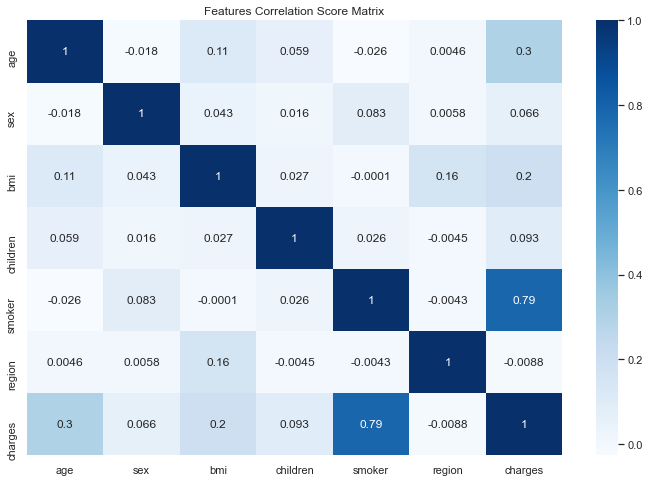

In [42]:
plt.figure(figsize=(12, 8))
plt.title('Features Correlation Score Matrix')
sns.heatmap(data= cleaned_data.corr(), cmap='Blues', annot=True)
plt.show()

## Build Model

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Scale data

In [235]:
from sklearn.preprocessing import MinMaxScaler

In [246]:
X = cleaned_data[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
Y = cleaned_data['charges'].values

In [247]:
# Split train test
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.3, random_state=7)

In [254]:
# Min max in range 0-1
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Scaled data
xTrainScaled = pd.DataFrame(x_scaler.fit_transform(xTrain) , columns= xTrain.columns.to_list())                         
xTestScaled = pd.DataFrame(x_scaler.fit_transform(xTest) , columns= xTest.columns.to_list())

yTrainScaled = pd.DataFrame(y_scaler.fit_transform(yTrain.reshape(-1, 1)), columns= ['charges'])

### Random Forest Regression

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [256]:
# Build random forest regression
random_forest = RandomForestRegressor(n_estimators=300)

In [257]:
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [259]:
yTrainScaled

,charges
0,0.356651
1,0.085760
2,0.017600
3,0.254664
4,0.585838
...,...
912,0.101672
913,0.022393
914,0.169455
915,0.000229


In [286]:
# Fitting model
rf_model = random_forest.fit(xTrainScaled, yTrainScaled.values.ravel())

In [287]:
# Prediction
yPredTrain = rf_model.predict(xTrainScaled)
yPredTest = rf_model.predict(xTestScaled)

In [288]:
# Invert predict values to normal
yPredTrain = y_scaler.inverse_transform(yPredTrain.reshape(-1, 1))
yPredTest = y_scaler.inverse_transform(yPredTest.reshape(-1, 1))

### Result of Random Forest Regression

In [289]:
# Check prediction values with error rate in train data
r2_train = r2_score(yTrain, yPredTrain)
mae_train = mean_absolute_error(yTrain, yPredTrain)
mse_train = mean_squared_error(yTrain, yPredTrain)
rmse_train = np.sqrt(mse_train)

In [290]:
print(f'R2 Score on train set RF Model: {r2_train:.4f}')
print(f'MAE on train set RF Model: {mae_train:.4f}')
print(f'MSE on train set RF Model: {mse_train:.4f}')
print(f'RMSE on train set RF Model: {rmse_train:.4f}')

R2 Score on train set RF Model: 0.9789
MAE on train set RF Model: 1001.4438
MSE on train set RF Model: 3199163.7445
RMSE on train set RF Model: 1788.6206


In [291]:
# Check prediction values with error rate
r2_test = r2_score(yTest, yPredTest)
mae_test = mean_absolute_error(yTest, yPredTest)
mse_test = mean_squared_error(yTest, yPredTest)
rmse_test = np.sqrt(mse_test)

In [292]:
print(f'R2 Score on test set RF Model: {r2_test:.4f}')
print(f'MAE on test set RF Model: {mae_test:.4f}')
print(f'MSE on test set RF Model: {mse_test:.4f}')
print(f'RMSE on test set RF Model: {rmse_test:.4f}')

R2 Score on test set RF Model: 0.8105
MAE on test set RF Model: 2727.4920
MSE on test set RF Model: 24840850.8398
RMSE on test set RF Model: 4984.0597


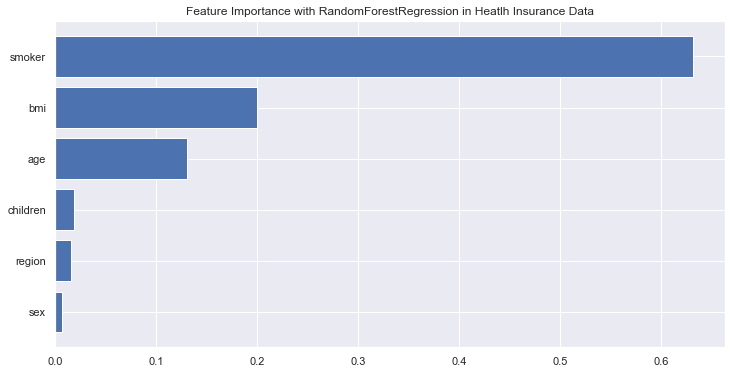

In [293]:
# Plot Feature Importance with Random Forest
sorted_index = rf_model.feature_importances_.argsort()

plt.figure(figsize=(12, 6))
plt.barh(X.columns[sorted_index], rf_model.feature_importances_[sorted_index])


plt.title("Feature Importance with RandomForestRegression in Heatlh Insurance Data")
plt.show()

### Try to improve base model with random search

In [294]:
from sklearn.model_selection import RandomizedSearchCV

In [295]:
# Set hyperparameter
n_estimators = [int(x) for x in np.linspace(100, 500, 10)]
max_depth = [int(x) for x in np.linspace(2, 15, 6)]
min_samples_split = [2, 3, 5, 7]
min_samples_leaf = [1, 3, 5, 7, 9]
max_features = ['auto', 'sqrt']
bootstrap = [True, False]

In [296]:
# Get parms into dict
param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap}

In [297]:
# Build model
random_forest = RandomForestRegressor()

# Setting random search
rf_randomGrid = RandomizedSearchCV(estimator= random_forest,
                                   param_distributions= param_grid,
                                   n_iter= 100,
                                   cv= 10,
                                   n_jobs= -1,
                                   verbose= 2)

In [298]:
# Fitting model
rf_randomGrid.fit(xTrainScaled, yTrainScaled.values.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 7, 9, 12, 15],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   verbose=2)

In [299]:
# Set of best hyperparms
rf_randomGrid.best_params_

{'n_estimators': 233,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [300]:
# Get hyperparms tuning model
rf_improveModel = rf_randomGrid.best_estimator_

In [301]:
rf_model

RandomForestRegressor(n_estimators=300)

In [302]:
rf_improveModel

RandomForestRegressor(max_depth=4, min_samples_leaf=7, min_samples_split=7,
                      n_estimators=233)

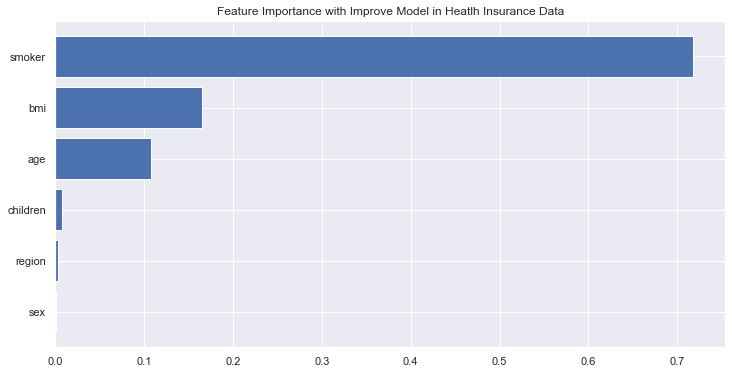

In [303]:
# Plot Feature Importance with Improve Model
sorted_index = rf_improveModel.feature_importances_.argsort()

plt.figure(figsize=(12, 6))
plt.barh(X.columns[sorted_index], rf_improveModel.feature_importances_[sorted_index])


plt.title("Feature Importance with Improve Model in Heatlh Insurance Data")
plt.show()

### Result after hyperparameter tuning

In [304]:
# Prediction
yPredTrainImprove = rf_improveModel.predict(xTrainScaled)
yPredTestImprove = rf_improveModel.predict(xTestScaled)

In [305]:
# Inverse predict values
yPredTrainImprove = y_scaler.inverse_transform(yPredTrainImprove.reshape(-1, 1))
yPredTestImprove = y_scaler.inverse_transform(yPredTestImprove.reshape(-1, 1))

In [306]:
# Check prediction values with error rate in train data
r2_trainImprove = r2_score(yTrain, yPredTrainImprove)
mae_trainImprove = mean_absolute_error(yTrain, yPredTrainImprove)
mse_trainImprove = mean_squared_error(yTrain, yPredTrainImprove)
rmse_trainImprove = np.sqrt(mse_trainImprove)

In [307]:
print(f'R2 Score on train set RF Model: {r2_trainImprove:.4f}')
print(f'MAE on train set RF Model: {mae_trainImprove:.4f}')
print(f'MSE on train set RF Model: {mse_trainImprove:.4f}')
print(f'RMSE on train set RF Model: {rmse_trainImprove:.4f}')

R2 Score on train set RF Model: 0.8783
MAE on train set RF Model: 2438.9572
MSE on train set RF Model: 18418681.5601
RMSE on train set RF Model: 4291.6991


In [308]:
r2_testImprove = r2_score(yTest, yPredTestImprove)
mae_testImprove = mean_absolute_error(yTest, yPredTestImprove)
mse_testImprove = mean_squared_error(yTest, yPredTestImprove)
rmse_testImprove = np.sqrt(mse_testImprove)

In [310]:
print(f'R2 Score on test set RF Model: {r2_testImprove:.4f}')
print(f'MAE on test set RF Model: {mae_testImprove:.4f}')
print(f'MSE on test set RF Model: {mse_testImprove:.4f}')
print(f'RMSE on test set RF Model: {rmse_testImprove:.4f}')

R2 Score on test set RF Model: 0.8356
MAE on test set RF Model: 2654.2721
MSE on test set RF Model: 21544073.6894
RMSE on test set RF Model: 4641.5594


### Visualization result

In [342]:
input_pred = {'yTest': yTest,
              'rfPred': yPredTest.reshape(-1, ),
              'rfPredImprove': yPredTestImprove.reshape(-1, )}

In [344]:
pred_df = pd.DataFrame(input_pred)
pred_df

,yTest,rfPred,rfPredImprove
0,10370.91255,15887.176490,11826.814836
1,22462.04375,41387.526977,41790.367461
2,11165.41765,11862.304003,12247.348752
3,8116.26885,10792.570529,8693.000642
4,11299.34300,11295.746676,12131.197715
...,...,...,...
389,1532.46970,1847.734536,3184.735043
390,2302.30000,3087.789707,4817.789882
391,11093.62290,15578.852055,13134.838076
392,11881.96960,16439.672663,13694.369412


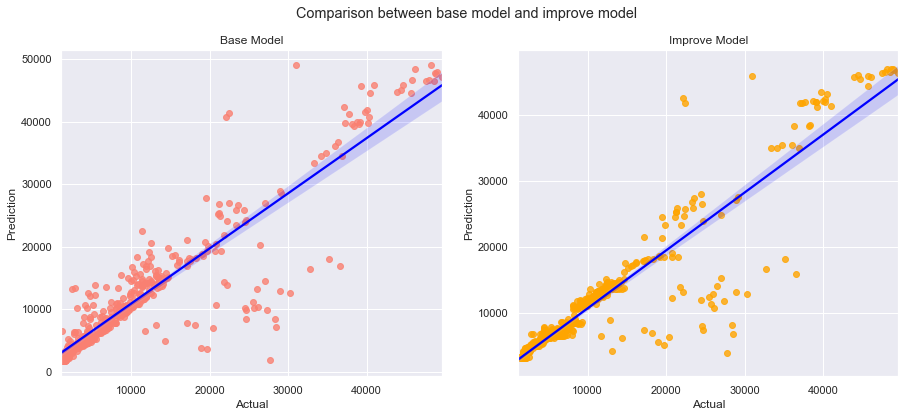

In [345]:
# Plot actual vs predict
fig3, ax3 = plt.subplots(1, 2, figsize=(15, 6))
sns.regplot(x= 'yTest', y= 'rfPred', data= pred_df, ax=ax3[0], 
            scatter_kws={'color': 'salmon'}, line_kws={'color': 'blue'})
sns.regplot(x= 'yTest', y= 'rfPredImprove', data= pred_df, ax=ax3[1],
            scatter_kws={'color': 'orange'}, line_kws={'color': 'blue'})


fig3.suptitle('Comparison between base model and improve model')
ax3[0].set_title('Base Model')
ax3[0].set_xlabel('Actual')
ax3[0].set_ylabel('Prediction')

ax3[1].set_title('Improve Model')
ax3[1].set_xlabel('Actual')
ax3[1].set_ylabel('Prediction')
plt.show()

## Save Model

In [346]:
# base model
joblib.dump(rf_model, '../work1/model/base_rfModel.joblib')

['../work1/model/base_rfModel.joblib']

In [347]:
# improve model
joblib.dump(rf_improveModel, '../work1/model/improve_rfModel.joblib')

['../work1/model/improve_rfModel.joblib']